# Graph features

## Introduction

When selecting events to generate cards from, we want them to be spread out across the family tree, not clumped around a particular individual or family.

We can achieve this by creating features (numeric values) that represent each individual or family's position in the overall family tree. The clustering step will take these features into account, so that different regions of the family tree will be represented by different clusters in the output.

## Import dependencies

In [1]:
import itertools

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from gedcom5.parser import GEDCOM5Parser
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

## Extract data from GEDCOM file

In [2]:
parser = GEDCOM5Parser()

with open("data/royal92.ged") as f:
    gedcom = parser.parse_string(f.read())

## Construct graph linking individuals and families

The first step is to create a [graph](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)) representation of our family tree. This model consists of nodes, which represent individuals and families, and edges which represent the relations between nodes.

The section below compares two different modelling approaches with a simple family tree consisting of two generations, before we move onto the real data.

### Modelling families

The GEDCOM file defines a family as a separate entity that links to the parents, children and any marriage events between the parents. We can deal with this information in two ways when constructing our graph:

1. We can ignore them and directly link parents to children.
2. We can model the families as nodes.

Marriages involve two individuals, so it's not clear which individual to take the features from, or how they should be combined. If the family is its own node, we can take the features associated that node.

The plots below show the differences between the two approaches.

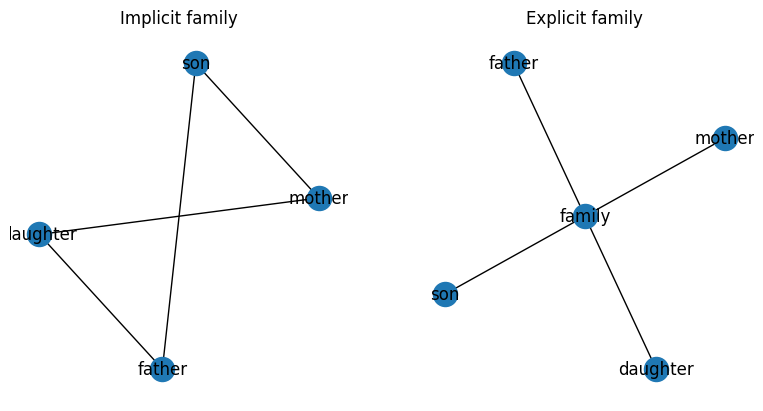

In [3]:
fig, ax = plt.subplots(ncols=2, figsize=(9.6, 4.8))

ax[0].set_title("Implicit family")

G = nx.Graph()

G.add_edge("mother", "son")
G.add_edge("mother", "daughter")
G.add_edge("father", "son")
G.add_edge("father", "daughter")

nx.draw_kamada_kawai(G, with_labels=True, ax=ax[0])

ax[1].set_title("Explicit family")

G = nx.Graph()

G.add_edge("mother", "family")
G.add_edge("father", "family")
G.add_edge("family", "son")
G.add_edge("family", "daughter")

nx.draw_kamada_kawai(G, with_labels=True, ax=ax[1])

### Modelling the GEDCOM data

We create a graph representation of a family tree as we have done above, but this time using all the data in the GEDCOM file. Plotting the graph is not a useful at this stage due to the thousands of nodes present.

In [4]:
G = nx.Graph()

G.add_edges_from(
    (indi.xref_id, fam.value)
    for indi in gedcom.indi
    for fam in itertools.chain(indi.famc, indi.fams)
)

G.number_of_nodes(), G.number_of_edges()

(4429, 4578)

## Construct the distance matrix

Now that we have our GEDCOM data represented as a graph, we can measure the distance between every individual/family and every other individual/family by counting the number of steps in the graph between one node and the other. We can store this information in matrix form, where the rows and columns represent nodes, and each cell represents the distance between a pair of cells.

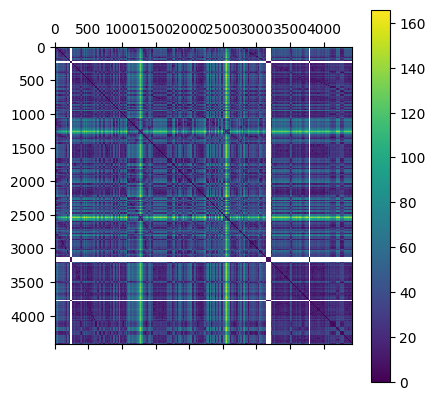

In [5]:
H = nx.convert_node_labels_to_integers(G, ordering="sorted")

shape = (
    H.number_of_nodes(),
    H.number_of_nodes(),
)

distance = np.full(shape, np.nan)
for i, jd in nx.all_pairs_shortest_path_length(H):
    for j, d in jd.items():
        distance[i, j] = d

plt.matshow(distance)
plt.colorbar();

Note some of the cells show up as white, which shows that there is no path between these two nodes in the graph. The GEDCOM file may contain multiple disjoint family trees, so there is no guarantee that everyone in the file is related to one another.

## Construct the affinity matrix

The matrix we constructed above represents the distance between nodes in the family tree, so the number is greater when two individuals are unrelated. What we really want is a matrix where the number is greater when two individuals are closely related, on a scale of zero to one:

- If the number is zero then the individuals are not related at all.
- If the number is one then the invidviduals are the same person.

We can create this matrix, known as the affinity matrix, from our distance matrix above.

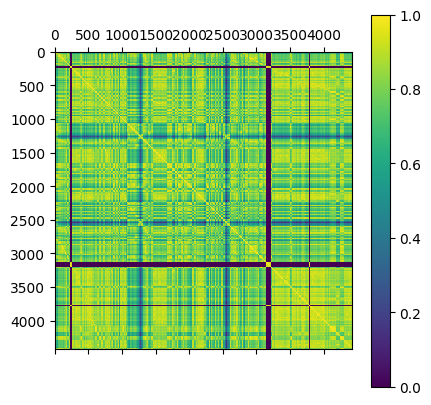

In [6]:
affinity = np.nan_to_num(1.0 - distance / np.nanmax(distance))

plt.matshow(affinity)
plt.colorbar();

## Order reduction

We now have a set of features that represent each node's position within the graph. The problem is that we have many thousands of features, which can make them challenging to visualise and use in downstream modelling techniques.

Ideally we want a smaller set of features that describe most of the variation. We can do this using [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis).

### Fit model

In [7]:
pca = PCA(whiten=True, svd_solver="full")
pca.fit(affinity)

PCA(svd_solver='full', whiten=True)

### Select number of components

We can work out how many components to select by specifying the mininmum amount of variance that should be explained by our reduced-order model. We can continue to select components until the explained variance is above this threshold. 

In [8]:
minimum_variance = 0.99

cumulative_ratio = np.cumsum(pca.explained_variance_ratio_)
n_components = np.searchsorted(cumulative_ratio, minimum_variance) + 1
n_components

4

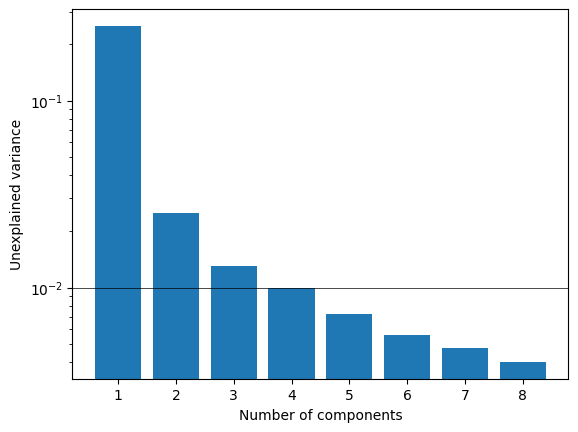

In [9]:
n_plot_components = n_components * 2
y = 1.0 - cumulative_ratio[:n_plot_components]
x = np.arange(y.size) + 1

fig, ax = plt.subplots()
ax.set_yscale("log")

ax.axhline(1.0 - minimum_variance, color="black", lw=0.5)

ax.set_xlabel("Number of components")
ax.set_ylabel("Unexplained variance")
plt.bar(x, y);

The plot shows that we can select the first bar where the unexplained variance is below the threshold, which is shown by the line.

Selecting a greater number of components will reduce the unexplained variance further, but with diminishing returns. It's likely that we can only get to zero unexplained variance by selecting every single component. So specifying a minimum explained variance is a compromise between capturing all of the variance and obtaining a useful set of features for downstream processing.

### Select components

We can now create a PCA transformer with the desired number of components, which will capture most of the variation in the affinity matrix.

The plot below shows what this looks like: each column represents a node in the graph, and the rows represent each of components. If two nodes have similar values for their respective components, then we would expect these nodes to be closely related in the graph.

It may be helpful to think of these components as analogous to genetic similarity; however, they are based only on record-keeping in a family tree, not real genetic data.

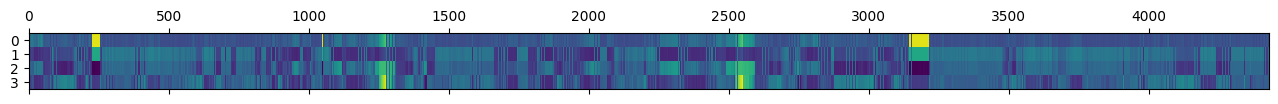

In [10]:
pca = PCA(
    n_components=n_components,
    whiten=True,
    svd_solver="arpack",
)
features = pca.fit_transform(affinity)

plt.matshow(features.T, aspect=50);

We can check that these components capture most of the variance in the original graph by using to reconstruct the original affinity matrix. We can see that a small amount of detail is lost but the overall structure is the same.

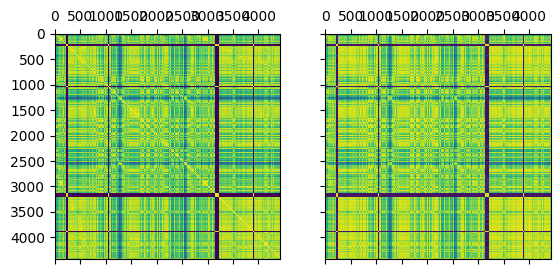

In [11]:
roundtrip = pca.inverse_transform(features)

fig, ax = plt.subplots(ncols=2, sharey=True)
ax[0].matshow(affinity)
ax[1].matshow(roundtrip);

## Clustering

These plots show how these features could be clustered in isolation.

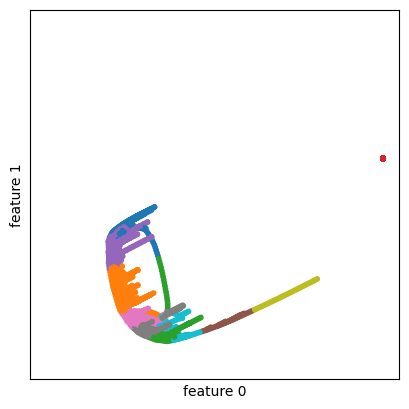

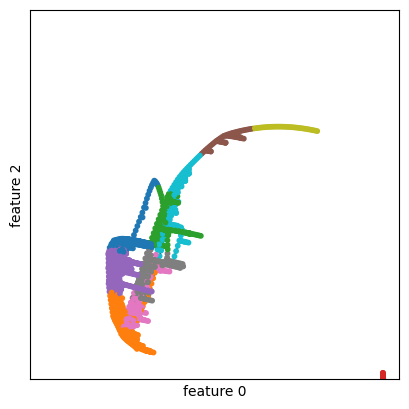

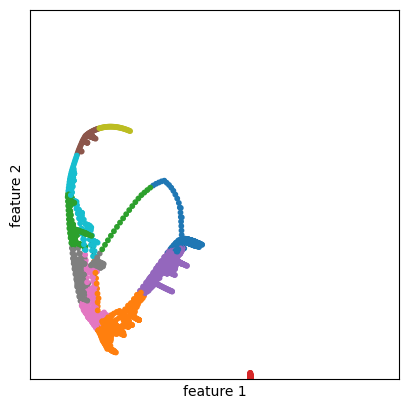

In [12]:
pipeline = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=10, n_init="auto", random_state=0),
)

labels = pipeline.fit_predict(features)

limit = np.min(features), np.max(features)

for i, (xi, yi) in enumerate([(0, 1), (0, 2), (1, 2)]):
    fig, ax = plt.subplots()

    ax.set_xlim(*limit)
    ax.set_ylim(*limit)
    ax.set_aspect(1)
    ax.set_xlabel(f"feature {xi}")
    ax.set_ylabel(f"feature {yi}")

    x = features[:, xi]
    y = features[:, yi]

    pos = dict(enumerate(zip(x, y)))
    color = labels / np.max(labels)
    nx.draw_networkx_edges(H, pos, ax=ax)
    ax.scatter(x, y, s=10.0, c=color, cmap="tab10");

## Export features

Finally, we export the numeric values so we can use them when selecting events.

In [13]:
df = pd.DataFrame(data=features, index=G.nodes)
df.to_csv("data/graph_features.csv")
df

,0,1,2,3
@I1@,0.577792,-0.360320,1.154970,-1.928660
@F42@,0.603071,-0.497670,0.963891,-1.813704
@F1@,0.624987,-0.633886,0.765493,-1.663857
@I2@,0.638989,-0.765938,0.561206,-1.449884
@F43@,0.635261,-0.885267,0.365468,-1.141019
...,...,...,...,...
@I3006@,-0.272970,-1.003930,-1.210368,0.002895
@I3007@,-0.330811,-0.918126,-1.364303,0.332938
@I3008@,-0.329129,-0.912464,-1.351566,0.359515
@I3009@,-0.599596,0.720528,0.369262,0.088158
